In [1]:
import os

# detect gpus
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import json

### 1. Data preprocessing

In [7]:
users = pd.read_csv('../data/users.csv')
games = pd.read_csv('../data/games.csv')

games_metadata_list = []
with open('../data/games_metadata.json', 'r') as f:
    for line in f:
        games_metadata_list.append(json.loads(line))
games_metadata = pd.json_normalize(games_metadata_list)

##### games_metadata.json

In [8]:
# 检查 description 列为空字符串的情况
empty_description = games_metadata[games_metadata['description'] == '']
print(f"Number of empty descriptions: {len(empty_description)}")

# 检查 tags 列为空列表的情况
empty_tags = games_metadata[games_metadata['tags'].apply(lambda x: len(x) == 0)]
print(f"Number of empty tags: {len(empty_tags)}")

# 打印出空 description 和空 tags 的行
print("Rows with empty descriptions:")
print(empty_description)

print("Rows with empty tags:")
print(empty_tags)

Number of empty descriptions: 10373
Number of empty tags: 1244
Rows with empty descriptions:
        app_id description                                               tags
1        22364                                                       [Action]
7       271850              [Strategy, Simulation, Action, RTS, World War II]
18      245950              [Action, RPG, FPS, Co-op, Shooter, Action RPG,...
21      305181                                            [Adventure, Action]
30      458790                          [Adventure, Soundtrack, Visual Novel]
...        ...         ...                                                ...
50866  2362300                                                             []
50867  2296380                                                             []
50868  1272080                                                             []
50869  1402110                                                             []
50871  2488510                                   

In [9]:
# drop rows with empty tags and empty descriptions
games_metadata = games_metadata[games_metadata['description'] != '']
print(f"Number of games after dropping empty descriptions: {len(games_metadata)}")
games_metadata = games_metadata[games_metadata['tags'].apply(lambda x: len(x) > 0)]
print(f"Number of games after dropping empty tags: {len(games_metadata)}")
games_metadata = games_metadata.reset_index(drop=True)

all_tags = list(set(tag for tags in games_metadata['tags'] for tag in tags))
tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags)

def encode_tags(tags_list):
    return tag_encoder.transform(tags_list)

games_metadata['tags_enc'] = games_metadata['tags'].apply(encode_tags)
num_tags = len(tag_encoder.classes_)
print(f"Number of unique tags: {num_tags}")

# drop columns that are not needed
games_metadata = games_metadata.drop(columns=['tags', 'description'])

Number of games after dropping empty descriptions: 40499
Number of games after dropping empty tags: 40484
Number of unique tags: 441


In [10]:
games_metadata

,app_id,tags_enc
0,13500,"[17, 23, 271, 384, 170, 341, 283, 391, 38, 77,..."
1,113020,"[79, 363, 192, 177, 210, 367, 266, 392, 17, 24..."
2,226560,"[439, 23, 374, 17, 384, 267, 167, 185, 341, 24..."
3,249050,"[318, 367, 395, 282, 192, 301, 329, 123, 23, 2..."
4,250180,"[31, 77, 17, 79, 338, 314, 210, 335, 3, 266, 1..."
...,...,...
40479,2515240,"[185, 38, 295, 23, 426, 150, 308, 105, 7, 167,..."
40480,2455060,"[301, 192, 262, 20, 148, 17, 173, 23, 7, 320, ..."
40481,1138640,"[127, 208, 75, 191, 112, 58, 327, 221, 96, 44,..."
40482,1687000,"[338, 49, 327, 223, 208, 301, 3, 366, 245, 267..."


#### games.csv

In [11]:
# check unique values in rating column
print(games['rating'].unique())

['Very Positive' 'Positive' 'Mixed' 'Mostly Positive'
 'Overwhelmingly Positive' 'Negative' 'Mostly Negative'
 'Overwhelmingly Negative' 'Very Negative']


In [12]:
# map rating to numerical values ['Very Positive' 'Positive' 'Mixed' 'Mostly Positive' 'Overwhelmingly Positive' 'Negative' 'Mostly Negative' 'Overwhelmingly Negative' 'Very Negative']
rating_map = {
    'Overwhelmingly Positive': 8,
    'Very Positive': 7,
    'Mostly Positive': 6,
    'Positive': 5,
    'Mixed': 4,
    'Mostly Negative': 3,
    'Negative': 2,
    'Overwhelmingly Negative': 1,
    'Very Negative': 0
}

games['rating'] = games['rating'].map(rating_map)
games['rating'].unique()

array([7, 5, 4, 6, 8, 2, 3, 1, 0], dtype=int64)

In [13]:
from datetime import datetime

games['app_id'] = games['app_id'].astype(int)

games['date_release'] = pd.to_datetime(games['date_release'])
current_date = datetime.now()
games['release_days'] = (current_date - games['date_release']).dt.days
games.drop('date_release', axis=1, inplace=True) 

games['win'] = games['win'].astype(int)
games['mac'] = games['mac'].astype(int)
games['linux'] = games['linux'].astype(int)

games['positive_ratio'] = games['positive_ratio'].astype(float)
games['user_reviews'] = games['user_reviews'].astype(int)

games['price_final'] = games['price_final'].astype(float)
games['price_original'] = games['price_original'].astype(float)
games['discount'] = games['discount'].astype(float)

games['steam_deck'] = games['steam_deck'].astype(int)

print(games.head())

   app_id                              title  win  mac  linux  rating  \
0   13500  Prince of Persia: Warrior Within™    1    0      0       7   
1   22364            BRINK: Agents of Change    1    0      0       5   
2  113020       Monaco: What's Yours Is Mine    1    1      1       7   
3  226560                 Escape Dead Island    1    0      0       4   
4  249050            Dungeon of the ENDLESS™    1    1      0       7   

   positive_ratio  user_reviews  price_final  price_original  discount  \
0            84.0          2199         9.99            9.99       0.0   
1            85.0            21         2.99            2.99       0.0   
2            92.0          3722        14.99           14.99       0.0   
3            61.0           873        14.99           14.99       0.0   
4            88.0          8784        11.99           11.99       0.0   

   steam_deck  release_days  
0           1          5799  
1           1          4814  
2           1          418

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd


# 1. 使用TF-IDF来提取标题中的特征
vectorizer = TfidfVectorizer(max_features=300)  # 限制最大特征数为300，以控制稀疏度
X_tfidf = vectorizer.fit_transform(games['title'])

# 2. 使用TruncatedSVD对TF-IDF矩阵进行降维，减少稀疏度
svd = TruncatedSVD(n_components=50)  # 降维到50维
X_reduced = svd.fit_transform(X_tfidf)

# 将降维后的结果加入到数据集中
games['title_vector'] = list(X_reduced)

# 检查处理后的结果
print(games[['title', 'title_vector']].head())
games.drop('title', axis=1, inplace=True)


                               title  \
0  Prince of Persia: Warrior Within™   
1            BRINK: Agents of Change   
2       Monaco: What's Yours Is Mine   
3                 Escape Dead Island   
4            Dungeon of the ENDLESS™   

                                        title_vector  
0  [0.1686721383422127, 0.37316500978498185, -0.0...  
1  [0.4056255597721264, 0.9066350252053336, -0.06...  
2  [0.005065989339974862, -0.002981952634817453, ...  
3  [0.01183061338254544, -0.0006497976562144328, ...  
4  [0.39205054341626794, 0.17049009914272958, -0....  


In [15]:
games

,app_id,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,release_days,title_vector
0,13500,1,0,0,7,84.0,2199,9.99,9.99,0.0,1,5799,"[0.1686721383422127, 0.37316500978498185, -0.0..."
1,22364,1,0,0,5,85.0,21,2.99,2.99,0.0,1,4814,"[0.4056255597721264, 0.9066350252053336, -0.06..."
2,113020,1,1,1,7,92.0,3722,14.99,14.99,0.0,1,4184,"[0.005065989339974862, -0.002981952634817453, ..."
3,226560,1,0,0,4,61.0,873,14.99,14.99,0.0,1,3611,"[0.01183061338254544, -0.0006497976562144328, ..."
4,249050,1,1,0,7,88.0,8784,11.99,11.99,0.0,1,3633,"[0.39205054341626794, 0.17049009914272958, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,1,0,0,7,96.0,101,22.00,0.00,0.0,1,375,"[0.23448365520008638, -0.10779076342902481, 0...."
50868,1272080,1,0,0,3,38.0,29458,40.00,0.00,0.0,1,382,"[0.0022172809332696853, -0.0010282503394551377..."
50869,1402110,1,0,0,7,89.0,1128,30.00,0.00,0.0,1,392,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50870,2272250,1,0,0,7,95.0,82,17.00,0.00,0.0,1,354,"[0.0016944785106124392, -0.0002396026882194697..."


#### recommendations.csv

In [16]:
recommendations = pd.read_csv('../data/recommendations.csv')
recommendations

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.0,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.0,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2.0,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4.0,1044289,41154792


In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

recommendations['date'] = pd.to_datetime(recommendations['date'], format='%Y-%m-%d')
recommendations['year'] = recommendations['date'].dt.year
recommendations['month'] = recommendations['date'].dt.month
recommendations['day'] = recommendations['date'].dt.day
recommendations['weekday'] = recommendations['date'].dt.weekday  # 周一为0，周日为6

recommendations.drop(columns=['date'], inplace=True)

recommendations.loc[:, 'helpful'] = recommendations['helpful'].astype(int)
recommendations.loc[:, 'funny'] = recommendations['funny'].astype(int)
recommendations.loc[:, 'hours'] = recommendations['hours'].astype(float)
# delete hours <= 2.0
recommendations = recommendations[recommendations['hours'] > 2.0]

recommendations.loc[:, 'is_recommended'] = recommendations['is_recommended'].map({True: 1, False: 0})

recommendations = recommendations.drop(columns=['review_id'])

print(recommendations.head())


C:\Users\Jinuo\AppData\Local\Temp\ipykernel_29800\959098349.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 0 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  recommendations.loc[:, 'is_recommended'] = recommendations['is_recommended'].map({True: 1, False: 0})


    app_id  helpful  funny  is_recommended  hours  user_id  year  month  day  \
0   975370        0      0               1   36.3    51580  2022     12   12   
1   304390        4      0               0   11.5     2586  2017      2   17   
2  1085660        2      0               1  336.5   253880  2019     11   17   
3   703080        0      0               1   27.4   259432  2022      9   23   
4   526870        0      0               1    7.9    23869  2021      1   10   

   weekday  
0        0  
1        4  
2        6  
3        4  
4        6  


In [18]:
recommendations

,app_id,helpful,funny,is_recommended,hours,user_id,year,month,day,weekday
0,975370,0,0,1,36.3,51580,2022,12,12,0
1,304390,4,0,0,11.5,2586,2017,2,17,4
2,1085660,2,0,1,336.5,253880,2019,11,17,6
3,703080,0,0,1,27.4,259432,2022,9,23,4
4,526870,0,0,1,7.9,23869,2021,1,10,6
...,...,...,...,...,...,...,...,...,...,...
41154788,391220,0,0,1,18.0,9958247,2021,4,28,2
41154789,633230,0,0,1,41.0,1606890,2021,2,15,0
41154790,758870,8,0,0,8.0,1786254,2019,7,18,3
41154792,696170,0,0,1,4.0,1044289,2018,6,11,0


In [19]:
# recommendations.to_csv('../data/processed/preprocessed_recommendations.csv', index=False)

#### users.csv

In [20]:
users

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


In [21]:
# check how many users have 0 reviews(in recommendations.csv)
users_with_reviews = recommendations['user_id'].unique()
users_without_reviews = users[~users['user_id'].isin(users_with_reviews)]
print(f"Number of users without reviews: {len(users_without_reviews)}")

# check how many users have 0 games
# only look at products column that <= 0 in users.csv
users_with_games = users[users['products'] > 0]
users_without_games = users[~users['user_id'].isin(users_with_games['user_id'])]
print(f"Number of users without games: {len(users_without_games)}")

Number of users without reviews: 1051082
Number of users without games: 139318


In [22]:
# drop users without reviews and games
users = users[users['user_id'].isin(users_with_reviews)]
users = users[users['user_id'].isin(users_with_games['user_id'])]
users = users.reset_index(drop=True)
users

,user_id,products,reviews
0,14020781,156,1
1,8762579,329,4
2,4820647,176,4
3,5167327,98,2
4,5664667,145,5
...,...,...,...
13139325,4897585,54,2
13139326,4898597,7,1
13139327,4902361,7,1
13139328,4902380,9,1


#### merge

In [23]:
games_full = pd.merge(games, games_metadata, on='app_id', how='inner')

data = pd.merge(recommendations, games_full, on='app_id', how='inner')

data = pd.merge(data, users, on='user_id', how='inner')

In [24]:
# print first row in full text
pd.set_option('display.max_columns', None)
# make sure column content(such as list) are also fully displayed
pd.set_option('display.max_colwidth', None)
print(data.head(1))
# print type of each column
print(data.dtypes)

    app_id  helpful  funny  is_recommended  hours  user_id  year  month  day  \
0  1544020       18      2               0    9.1  9254726  2022     12    2   

   weekday  win  mac  linux  rating  positive_ratio  user_reviews  \
0        4    1    0      0       4            62.0         21737   

   price_final  price_original  discount  steam_deck  release_days  \
0        59.99           59.99       0.0           1           676   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [25]:
# check detailed type of tags_enc and title_vector
print(type(data['tags_enc'][0]))
print(type(data['title_vector'][0]))

# # convert tags_enc and title_vector to list
# data['tags_enc'] = data['tags_enc'].apply(lambda x: list(x))
# data['title_vector'] = data['title_vector'].apply(lambda x: list(x))

# # check detailed type of tags_enc and title_vector
# print(type(data['tags_enc'][0]))
# print(type(data['title_vector'][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [26]:
# check if there are any missing values
print(data.isnull().sum())

app_id            0
helpful           0
funny             0
is_recommended    0
hours             0
user_id           0
year              0
month             0
day               0
weekday           0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
release_days      0
title_vector      0
tags_enc          0
products          0
reviews           0
dtype: int64


In [27]:
# save the processed full dataset
# data.to_csv('../data/processed/processed_full.csv', index=False)

### 2. Feature Engineering

In [32]:
# shut down full text display
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')
data.head(1)

,app_id,helpful,funny,is_recommended,hours,user_id,year,month,day,weekday,...,user_reviews,price_final,price_original,discount,steam_deck,release_days,title_vector,tags_enc,products,reviews
0,1544020,18,2,0,9.1,9254726,2022,12,2,4,...,21737,59.99,59.99,0.0,1,676,"[0.9077150940854771, -0.4108130942672215, -0.0...","[185, 329, 375, 385, 356, 335, 21, 384, 298, 7...",724,34


In [31]:
from sklearn.model_selection import train_test_split

# 特征列
feature_columns = ['user_id', 'app_id', 'helpful', 'funny', 'hours', 'year', 'month', 'day', 'weekday',
                   'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final',
                   'price_original', 'discount', 'steam_deck', 'release_days', 'products', 'reviews']

# 将 numpy 数组展开并添加到特征列中
title_vector_array = np.stack(data['title_vector'].values)
# 找到最长的 tags_enc 数组长度
max_len = max(len(x) for x in data['tags_enc'].values)
# 填充 tags_enc 数组
tags_enc_array = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in data['tags_enc'].values])

# 合并所有特征
X_numeric = data[feature_columns].values
X = np.hstack((X_numeric, title_vector_array, tags_enc_array))

# 目标变量
y = data['is_recommended'].values

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# save train and test data
np.save('../data/train/X_train.npy', X_train)
np.save('../data/test/X_test.npy', X_test)
np.save('../data/train/y_train.npy', y_train)
np.save('../data/test/y_test.npy', y_test)

### 3. Model training

In [3]:
# read train and test data
X_train = np.load('../data/train/X_train.npy')
X_test = np.load('../data/test/X_test.npy')
y_train = np.load('../data/train/y_train.npy')
y_test = np.load('../data/test/y_test.npy')

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Model baseline1

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#### Model baseline2

In [5]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout, Add, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping


def create_model(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # 初始层
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # 第一层残差块
    shortcut = x
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 第二层残差块，调整 shortcut 的维度
    shortcut = x
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    
    # 使用 Dense 层改变 shortcut 的维度
    shortcut = Dense(256)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 第三层残差块，继续调整 shortcut 的维度
    shortcut = x
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    
    shortcut = Dense(128)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 第四层残差块，继续调整 shortcut 的维度
    shortcut = x
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    
    shortcut = Dense(64)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 输出层
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model


model = create_model(X_train.shape[1])

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 92)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          47616       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512)         2048        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['batch_normalization[0][0]']

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

batch_size = 512
epochs = 100

In [8]:
# check current device
a = tf.constant(1.0)
print("Device used for computation:", a.device)

Device used for computation: /job:localhost/replica:0/task:0/device:GPU:0


In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

model.save('../model/resnet_baseline2.h5')

Epoch 1/100
26485/26485 [==============================] - 217s 8ms/step - loss: 0.2952 - accuracy: 0.8899 - val_loss: 0.2843 - val_accuracy: 0.8932
Epoch 2/100
26485/26485 [==============================] - 209s 8ms/step - loss: 0.2859 - accuracy: 0.8927 - val_loss: 0.2815 - val_accuracy: 0.8941
Epoch 3/100
26485/26485 [==============================] - 206s 8ms/step - loss: 0.2836 - accuracy: 0.8934 - val_loss: 0.2798 - val_accuracy: 0.8946
Epoch 4/100
26485/26485 [==============================] - 210s 8ms/step - loss: 0.2822 - accuracy: 0.8938 - val_loss: 0.2789 - val_accuracy: 0.8950
Epoch 5/100
26485/26485 [==============================] - 209s 8ms/step - loss: 0.2813 - accuracy: 0.8941 - val_loss: 0.2782 - val_accuracy: 0.8951
Epoch 6/100
26485/26485 [==============================] - 210s 8ms/step - loss: 0.2806 - accuracy: 0.8944 - val_loss: 0.2780 - val_accuracy: 0.8954
Epoch 7/100
26485/26485 [==============================] - 208s 8ms/step - loss: 0.2800 - accuracy: 0.8945

#### Another training(not you)

In [9]:
# training!
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('../model/baseline1.h5', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=5,
                    batch_size=256,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
52970/52970 [==============================] - 142s 3ms/step - loss: 0.2987 - accuracy: 0.8894 - val_loss: 0.2962 - val_accuracy: 0.8916
Epoch 2/5
52970/52970 [==============================] - 142s 3ms/step - loss: 0.2924 - accuracy: 0.8910 - val_loss: 0.2936 - val_accuracy: 0.8919
Epoch 3/5
52970/52970 [==============================] - 139s 3ms/step - loss: 0.2907 - accuracy: 0.8914 - val_loss: 0.2897 - val_accuracy: 0.8922
Epoch 4/5
52970/52970 [==============================] - 147s 3ms/step - loss: 0.2898 - accuracy: 0.8917 - val_loss: 0.2872 - val_accuracy: 0.8929
Epoch 5/5
52970/52970 [==============================] - 140s 3ms/step - loss: 0.2892 - accuracy: 0.8919 - val_loss: 0.2899 - val_accuracy: 0.8928


### 4. Model Evaluation

d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

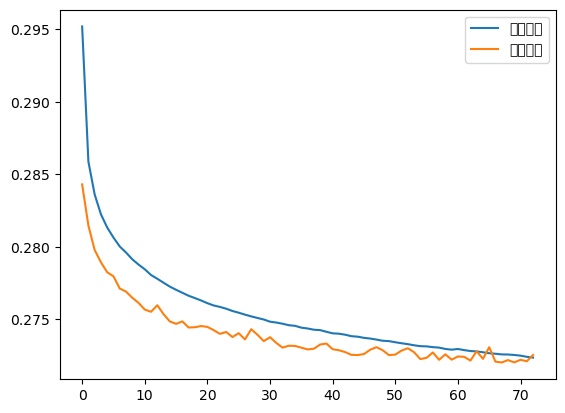

d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


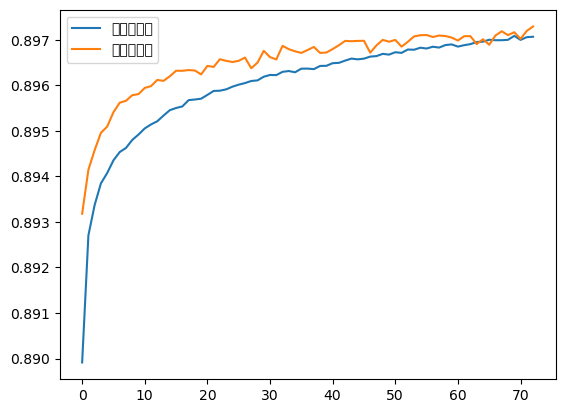

In [10]:
import matplotlib.pyplot as plt

# 绘制损失曲线
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.legend()
plt.show()

# 绘制准确率曲线（如果是分类问题）
plt.plot(history.history['accuracy'], label='训练准确率')
plt.plot(history.history['val_accuracy'], label='验证准确率')
plt.legend()
plt.show()

In [12]:
# load best model
from keras.models import load_model

best_model = load_model('../model/resnet_baseline2.h5')

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"测试集损失：{loss}")
print(f"测试集准确率：{accuracy}")

105940/105940 [==============================] - 223s 2ms/step - loss: 0.2720 - accuracy: 0.8972
测试集损失：0.2720302939414978
测试集准确率：0.8971896767616272


### 5. Recommendation function